In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import pingouin as pg

In [2]:
df = pd.read_csv('../../results/results.csv')

flags = df['flag'].unique()
progs = df['program'].unique()

# column for statistical tests
df_col = 'execution_time'

print(f'total program-flag combinations: {(len(flags)) * len(progs)}')

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

total program-flag combinations: 891


In [3]:
# Remove outliers from the initial data
col = 'pkg_energy'
total_outliers = 0

for prog in progs:
    for flag in flags:
        data = df[(df['program'] == prog) & (df['flag'] == flag)]
        q75, q25 = np.percentile(data.loc[:,col],[75,25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        data.loc[data[col] < min,col] = np.nan
        data.loc[data[col] > max,col] = np.nan

        outliers_count = data[col].isnull().sum()
        total_outliers += outliers_count

        # remove outliers
        df[(df['program'] == prog) & (df['flag'] == flag)] = data.dropna(axis=0)

print(f'Removed a total of {total_outliers} outliers')

/home/bernas/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Removed a total of 443 outliers


In [4]:
# Perform Shapiro-Wilks test for each program-flag combination
# to check if the data follows a normal distribution
norm_df = []

for prog in progs:
    for flag in flags:
        w, pvalue = stats.shapiro(df[(df['flag'] == flag) & (df['program'] == prog)][df_col])
        norm_df.append([prog, flag, w, pvalue, pvalue >= 0.05])

norm_df = pd.DataFrame(norm_df, columns=['prog', 'flag', 'sw_w', 'sw_p', 'is_normal'])
norm_count = len(norm_df[norm_df['is_normal'] == True])

print(f'prog-flag combinations that follow a normal distribution: {norm_count}')
# display(norm_df)

prog-flag combinations that follow a normal distribution: 732


In [5]:
# Check Homogeneity of variances

# For data drawn from NORMAL distributions
# Perform Bartlett's test
norm_progs = norm_df[norm_df['is_normal'] == True]['prog'].unique()

homo_df = []
for prog in norm_progs:
    norm_flags = norm_df[(norm_df['prog'] == prog) & (norm_df['is_normal'] == True)]['flag'].values.tolist()

    if (len(norm_flags) <= 1 or '-O0' not in norm_flags): continue

    norm_flags.remove('-O0')

    for flag in norm_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)][df_col] for f in [flag, '-O0']]
        w, pvalue = stats.bartlett(*data)
        homo_df.append(['bartlett', prog, flag, w, pvalue, pvalue >= 0.12])

# For data that is not drawn from NORMAL distributions
# Perform Lavene's test
non_norm_progs = norm_df[norm_df['is_normal'] == False]['prog'].unique()
for prog in non_norm_progs:
    non_norm_flags = norm_df[(norm_df['prog'] == prog) & (norm_df['is_normal'] == False)]['flag'].values.tolist()

    if (len(non_norm_flags) <= 1 or '-O0' not in non_norm_flags): continue
    non_norm_flags.remove('-O0')

    for flag in non_norm_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)][df_col] for f in [flag, '-O0']]
        w, pvalue = stats.levene(*data)
        homo_df.append(['levene', prog, flag, w, pvalue, pvalue > 0.05])

homo_df = pd.DataFrame(homo_df, columns=['test','prog', 'flag', 'w', 'p', 'eq_var'])
print(homo_df)

homo_norm_count = len(homo_df[(homo_df['eq_var'] == True) & (homo_df['test'] == 'bartlett')])
homo_non_norm_count = len(homo_df[(homo_df['eq_var'] == True) & (homo_df['test'] == 'levene')])

print(f'\nnormal prog-flag combinations with homogeneity of variances: {homo_norm_count}')
print(f'\nnon-normal prog-flag combinations with homogeneity of variances: {homo_non_norm_count}')

         test            prog                         flag        w       p  \
0    bartlett       cacheprof                 -fcase-merge  1.16588 0.28025   
1    bartlett       cacheprof               -fcase-folding  0.94878 0.33003   
2    bartlett       cacheprof                 -fcall-arity  0.08342 0.77271   
3    bartlett       cacheprof              -fexitification 27.75674 0.00000   
4    bartlett       cacheprof     -fcmm-elim-common-blocks  9.27673 0.00232   
5    bartlett       cacheprof                   -fcmm-sink 16.34941 0.00005   
6    bartlett       cacheprof                   -fcpr-anal 16.18212 0.00006   
7    bartlett       cacheprof                        -fcse  3.65539 0.05589   
8    bartlett       cacheprof                    -fstg-cse  3.53449 0.06010   
9    bartlett       cacheprof            -fdmd-tx-dict-sel 14.90820 0.00011   
10   bartlett       cacheprof           -fdo-eta-reduction  8.36234 0.00383   
11   bartlett       cacheprof    -fdo-lambda-eta-exp

In [6]:
values = []

for prog in progs:
    data = [df[(df['flag'] == flag) & (df['program'] == prog)][df_col] for flag in flags]
    fvalue, pvalue = stats.f_oneway(*data)
    values.append([prog, fvalue, pvalue, pvalue < 0.05])

values_df = pd.DataFrame(values, columns=['Program', 'F Value', 'P Value', 'p < 0.05'])
print(values_df)

           Program      F Value  P Value  p < 0.05
0        cacheprof    112.09675  0.00000      True
1      constraints     48.41782  0.00000      True
2             hash     56.84446  0.00000      True
3       bernouilli      7.57622  0.00000      True
4           exp3_8      2.98761  0.00001      True
5      gen_regexps    984.22883  0.00000      True
6        integrate    282.73102  0.00000      True
7             anna     20.64660  0.00000      True
8   real_cacheprof     26.18552  0.00000      True
9        compress2      7.56994  0.00000      True
10    binary-trees     29.84874  0.00000      True
11           fasta    770.62969  0.00000      True
12    k-nucleotide    198.46574  0.00000      True
13        pidigits      5.54118  0.00000      True
14     callback001      5.89052  0.00000      True
15     callback002      1.57970  0.04125      True
16            chan      6.45319  0.00000      True
17            ansi     36.16587  0.00000      True
18            atom      2.30563

In [7]:
# ANOVA only considering the program-flag combinations that respect all assumptions

values = []
for prog in homo_df[homo_df['eq_var'] == True]['prog'].unique():
    p_flags = homo_df[homo_df['prog'] == prog]['flag']

    for flag in p_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)][df_col] for f in [flag, '-O0']]
        fvalue, pvalue = stats.f_oneway(*data)
        values.append([prog, flag, fvalue, pvalue, pvalue < 0.05])

values_df = pd.DataFrame(values, columns=['Program', 'Flag', 'F Value', 'P Value', 'p < 0.05'])

count_val = len(values_df[values_df['p < 0.05'] == True])
total_comb = (len(flags) - 1) * len(progs)
print(f'prog-flag combinations that are comparable: {count_val}/{total_comb} ({count_val/total_comb * 100:.0f} %)\n')
print(f'non-comparable {len(values_df[values_df["p < 0.05"] == False])}')

flags_count = []
for flag in flags:
    c = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == True)])
    p = values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == True)]['Program'].unique()
    
    nd = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)])
    nd_p = values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)]['Program'].unique()
    
    na = len(progs) - c - nd
    na_p = list(filter(lambda x: x not in [*p, *nd_p], progs))
    
    flags_count.append([flag, c, p, nd, nd_p, na, na_p])
flags_df = pd.DataFrame(flags_count, columns=['Flag', 'Count', 'Programs', 'NotDiff', 'NotDiffProgs', 'NoAssu', 'NoAssuProgs'])
# flags_df = pd.DataFrame(flags_count, columns=['Flag', 'Count', 'Programs'])
flags_df = flags_df.drop(flags_df.index[0])
# display(flags_df)
# print(flags_df.to_latex(index=False))
print(flags_df[['Flag', 'Count', 'NotDiff', 'NoAssu']].to_latex(index=False))

print(np.sum(flags_df['Count']))
print(np.sum(flags_df['NotDiff']))
print(np.sum(flags_df['NoAssu']))

prog-flag combinations that are comparable: 260/858 (30 %)

non-comparable 365
\begin{tabular}{lrrr}
\toprule
                       Flag &  Count &  NotDiff &  NoAssu \\
\midrule
               -fcase-merge &      3 &       25 &       5 \\
             -fcase-folding &      2 &       19 &      12 \\
               -fcall-arity &      7 &       17 &       9 \\
            -fexitification &      8 &       18 &       7 \\
   -fcmm-elim-common-blocks &     14 &        9 &      10 \\
                 -fcmm-sink &     22 &        3 &       8 \\
                 -fcpr-anal &      6 &       17 &      10 \\
                      -fcse &      7 &       15 &      11 \\
                  -fstg-cse &     13 &        8 &      12 \\
          -fdmd-tx-dict-sel &     10 &       19 &       4 \\
         -fdo-eta-reduction &      7 &       17 &       9 \\
  -fdo-lambda-eta-expansion &      9 &       13 &      11 \\
                 -ffloat-in &      8 &       14 &      11 \\
            -ffull-laziness

/tmp/ipykernel_9711/4090341910.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(flags_df[['Flag', 'Count', 'NotDiff', 'NoAssu']].to_latex(index=False))


In [8]:
# Calculate effect size
# Perform Hedge's g (n < 20)

# effsize > 0 ==> optimized program consumed more energy
# effsize < 0 ==> optimized program consumed less energy

# effsize = 0.2 ==> small
# effsize = 0.5 ==> medium
# effsize = 0.8 ==> large

eff_df = []
for _, row in flags_df.iterrows():
    flag = row['Flag']
    for prog in row['Programs']:
        effsize = pg.compute_effsize(
            df[(df['flag'] == flag) & (df['program'] == prog)][df_col],
            df[(df['flag'] == '-O0') & (df['program'] == prog)][df_col],
            eftype='hedges'
        )
        eff_df.append([flag, prog, effsize])
eff_df = pd.DataFrame(eff_df, columns=['flag', 'prog', 'effsize']) 
print(eff_df.to_latex(index=False))

# print(np.min(np.abs(eff_df['effsize'])))


\begin{tabular}{llr}
\toprule
                       flag &           prog &   effsize \\
\midrule
               -fcase-merge &          fasta &  21.67470 \\
               -fcase-merge &         awards &   5.86763 \\
               -fcase-merge &   cryptarithm1 &   1.15568 \\
             -fcase-folding &         awards &   7.88849 \\
             -fcase-folding &   cryptarithm1 &   0.92494 \\
               -fcall-arity &          fasta &  11.82593 \\
               -fcall-arity &           ansi &   0.95425 \\
               -fcall-arity &         awards &   6.41089 \\
               -fcall-arity &             gg &  -1.21307 \\
               -fcall-arity &         parser &   1.15155 \\
               -fcall-arity &   cryptarithm1 &   2.84485 \\
               -fcall-arity &         queens &  -0.96027 \\
            -fexitification &      cacheprof &  -5.52310 \\
            -fexitification &    gen\_regexps &   6.63278 \\
            -fexitification &           anna &  -0.98117 \\


/tmp/ipykernel_9711/1232322064.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(eff_df.to_latex(index=False))


In [9]:
# Average of effect size for each flag
m_eff_df = []
for flag in eff_df['flag'].unique():
    pos = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] > 0)])
    neg = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] < 0)])
    m_eff_df.append([flag, pos, neg, neg/(pos+neg)])
m_eff_df = pd.DataFrame(m_eff_df, columns=['flag', 'pos', 'neg', '%neg'])
print(m_eff_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                       flag &  pos &  neg &    \%neg \\
\midrule
               -fcase-merge &    3 &    0 & 0.00000 \\
             -fcase-folding &    2 &    0 & 0.00000 \\
               -fcall-arity &    5 &    2 & 0.28571 \\
            -fexitification &    4 &    4 & 0.50000 \\
   -fcmm-elim-common-blocks &    7 &    7 & 0.50000 \\
                 -fcmm-sink &    7 &   15 & 0.68182 \\
                 -fcpr-anal &    3 &    3 & 0.50000 \\
                      -fcse &    4 &    3 & 0.42857 \\
                  -fstg-cse &    6 &    7 & 0.53846 \\
          -fdmd-tx-dict-sel &    6 &    4 & 0.40000 \\
         -fdo-eta-reduction &    3 &    4 & 0.57143 \\
  -fdo-lambda-eta-expansion &    6 &    3 & 0.33333 \\
                 -ffloat-in &    5 &    3 & 0.37500 \\
            -ffull-laziness &    6 &    5 & 0.45455 \\
           -fignore-asserts &    6 &    4 & 0.40000 \\
            -fliberate-case &    3 &    3 & 0.50000 \\
            -floopificat

/tmp/ipykernel_9711/3547157127.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m_eff_df.to_latex(index=False))


,flag,# e > 0,# e = 0,# e < 0,% > 0,% = 0,% < 0
0,-fcase-merge,3,25,0,10.71,89.29,0.00
1,-fcase-folding,2,19,0,9.52,90.48,0.00
2,-fcall-arity,5,17,2,20.83,70.83,8.33
3,-fexitification,4,18,4,15.38,69.23,15.38
4,-fcmm-elim-common-blocks,7,9,7,30.43,39.13,30.43
5,-fcmm-sink,7,3,15,28.00,12.00,60.00
6,-fcpr-anal,3,17,3,13.04,73.91,13.04
7,-fcse,4,15,3,18.18,68.18,13.64
8,-fstg-cse,6,8,7,28.57,38.10,33.33
9,-fdmd-tx-dict-sel,6,19,4,20.69,65.52,13.79


# e > 0: 142
# e < 0: 118
# flags pos > neg: 17
# flags pos < neg: 5
% > 0: 22.790584253967946
% = 0: 58.30772730325839
% < 0: 18.90168844277367
100.0


<AxesSubplot:xlabel='% < 0', ylabel='Count'>

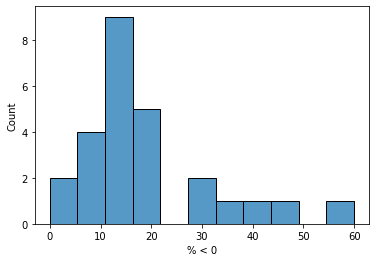

In [10]:
m_eff_df = []
for flag in eff_df['flag'].unique():
    pos = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] > 0)])
    neg = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] < 0)])
    nul = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)])

    t = pos + neg + nul


    p_pos = eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] > 0)]['prog'].unique()
    p_neg = eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] < 0)]['prog'].unique()
    # m_eff_df.append([flag, pos, neg, neg/(pos+neg), p_pos, p_neg])
    m_eff_df.append([flag, pos, nul, neg, pos * 100 / t, nul * 100/ t, neg * 100/ t])
# m_eff_df = pd.DataFrame(m_eff_df, columns=['flag', 'pos', 'neg', '% neg', 'pos progs', 'neg progs'])
m_eff_df = pd.DataFrame(m_eff_df, columns=['flag', '# e > 0', '# e = 0', '# e < 0', '% > 0', '% = 0', '% < 0'])
# print(m_eff_df.to_latex(index=False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(m_eff_df)
# print(m_eff_df.to_latex(index=False))

avg1 = np.average(m_eff_df['% > 0'])
avg2 = np.average(m_eff_df['% = 0'])
avg3 = np.average(m_eff_df['% < 0'])

print(f'# e > 0: {np.sum(m_eff_df["# e > 0"])}')
print(f'# e < 0: {np.sum(m_eff_df["# e < 0"])}')

print(f'# flags pos > neg: {len(m_eff_df[(m_eff_df["# e > 0"] > m_eff_df["# e < 0"])])}')
print(f'# flags pos < neg: {len(m_eff_df[(m_eff_df["# e > 0"] < m_eff_df["# e < 0"])])}')

print(f'% > 0: {avg1}')
print(f'% = 0: {avg2}')
print(f'% < 0: {avg3}')
print(avg1 + avg2 + avg3)

sns.histplot(m_eff_df['% < 0'])

In [11]:
prog_eff_df = []
for prog in eff_df['prog'].unique():
    pos = len(eff_df[(eff_df['prog'] == prog) & (eff_df['effsize'] > 0)])
    neg = len(eff_df[(eff_df['prog'] == prog) & (eff_df['effsize'] < 0)])
    nul = len(values_df[(values_df['Program'] == prog) & (values_df['p < 0.05'] == False)])
    t = pos + neg + nul

    prog_eff_df.append([prog, pos, nul, neg, pos * 100 / t, nul * 100 / t, neg * 100 / t])

prog_eff_df = pd.DataFrame(prog_eff_df, columns=['prog', 'pos', 'nul', 'neg', '% pos', '% nul', '% neg'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(prog_eff_df.to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
          prog &  pos &  nul &  neg &  \% pos &  \% nul &  \% neg \\
\midrule
         fasta &   22 &    0 &    0 & 100.00 &   0.00 &   0.00 \\
        awards &   23 &    0 &    0 & 100.00 &   0.00 &   0.00 \\
  cryptarithm1 &   21 &    3 &    1 &  84.00 &  12.00 &   4.00 \\
          ansi &    2 &   12 &    3 &  11.76 &  70.59 &  17.65 \\
            gg &    0 &    4 &   17 &   0.00 &  19.05 &  80.95 \\
        parser &    5 &   14 &    3 &  22.73 &  63.64 &  13.64 \\
        queens &    9 &    9 &    4 &  40.91 &  40.91 &  18.18 \\
     cacheprof &    0 &    3 &   23 &   0.00 &  11.54 &  88.46 \\
   gen\_regexps &   19 &    3 &    2 &  79.17 &  12.50 &   8.33 \\
          anna &    1 &   12 &   13 &   3.85 &  46.15 &  50.00 \\
     compress2 &    0 &   18 &    3 &   0.00 &  85.71 &  14.29 \\
   constraints &    4 &   17 &    1 &  18.18 &  77.27 &   4.55 \\
          hash &    9 &   11 &    5 &  36.00 &  44.00 &  20.00 \\
        exp3\_8 &    4 &   12

/tmp/ipykernel_9711/1666305573.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(prog_eff_df.to_latex(index=False))


In [12]:
benchmark = 'fasta'
# print(eff_df[eff_df['prog'] == benchmark][['flag', 'effsize']].to_latex(index=False))
display(eff_df[eff_df['prog'] == benchmark][['flag', 'effsize']])

,flag,effsize
0,-fcase-merge,21.67
5,-fcall-arity,11.83
16,-fexitification,27.30
25,-fcmm-elim-common-blocks,21.30
43,-fcmm-sink,43.46
65,-fcse,17.86
76,-fstg-cse,20.02
87,-fdmd-tx-dict-sel,20.37
103,-fdo-lambda-eta-expansion,14.09
111,-ffloat-in,19.55


In [13]:
# generate latex table for effect size
lines = list(eff_df.to_latex(index=False).split("\n"))[4:-3]
n = len(lines)
# lines = [str(i) for i in range(0, 10)]

data = []
for i in range(0, n//2 if n%2 == 0 else n//2 + 1):
    l = " & & \\\\"

    if n%2 == 0:
        l = lines[n//2 + i]
    elif i + n//2 + 1 != n:
        l = lines[n//2 + i + 1]

    data.append(f'{lines[i][:-4]} & & {l}')

for l in data:
    print(l)

               -fcase-merge &          fasta &    21.6 & &            -fignore-asserts &    gen\_regexps &     6.37 \\
               -fcase-merge &         awards &     5.8 & &            -fignore-asserts &           anna &    -1.08 \\
               -fcase-merge &   cryptarithm1 &     1.1 & &            -fignore-asserts &          fasta &    25.73 \\
             -fcase-folding &         awards &     7.8 & &            -fignore-asserts &         awards &     8.03 \\
             -fcase-folding &   cryptarithm1 &     0.9 & &            -fignore-asserts &             gg &    -2.30 \\
               -fcall-arity &          fasta &    11.8 & &            -fignore-asserts &   cryptarithm1 &     2.44 \\
               -fcall-arity &           ansi &     0.9 & &            -fignore-asserts &         parfib &    -1.70 \\
               -fcall-arity &         awards &     6.4 & &             -fliberate-case &      cacheprof &    -5.62 \\
               -fcall-arity &             gg &    -1.2 

/tmp/ipykernel_9711/4062300238.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines = list(eff_df.to_latex(index=False).split("\n"))[4:-3]
